## Import Packages

In [194]:
import nba_api.stats.endpoints as nba
import nba_api as static
import config
import pandas as pd
import mysql_helper
import mysql.connector

#### Connect to the Database

In [195]:
dbname = "nba"
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname)
cursor = cnx.cursor(buffered=True)

#### Select all game IDs from the game_logs table to fetch the boxscores from these games

In [ ]:
stmt = """SELECT GAME_ID from nba.box_score"""
cursor.execute(stmt)
ids = cursor.fetchall()

In [4]:
ids_df = pd.DataFrame(ids)
ids_df.columns = ['game_id']

#### Use one game ID from the above dataframe to generate a box score to build the box_score table from

In [35]:
box_score = nba.BoxScoreTraditionalV2(game_id='0021900002').get_data_frames()[0]

#### Create a primary key for each row, change the title of the column for turnovers because the existing one is an SQL keyword and drop the original column

In [37]:
box_score['pk'] = str(box_score['PLAYER_ID']) + box_score['GAME_ID']
box_score['TOS'] = box_score['TO']
box_score.drop('TO', axis=1, inplace=True)

In [49]:
box_score.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk',
       'TOS'],
      dtype='object')

#### Use the mysql_helper module to create the box_score table directly from the dataframe returned from the NBA api above, using the 'pk' column as the primary key

In [40]:
flatiron = mysql_helper.Connection(config.host, config.user, config.password)
nba_db = mysql_helper.DataBase(flatiron, 'nba')

In [50]:
nba_db.table_fromDf(box_score,'box_score', 'pk')

CREATE TABLE IF NOT EXISTS box_score (GAME_ID VARCHAR (250), TEAM_ID INT (64), TEAM_ABBREVIATION VARCHAR (250), TEAM_CITY VARCHAR (250), PLAYER_ID INT (64), PLAYER_NAME VARCHAR (250), START_POSITION VARCHAR (250), COMMENT VARCHAR (250), MIN VARCHAR (250), FGM FLOAT, FGA FLOAT, FG_PCT FLOAT, FG3M FLOAT, FG3A FLOAT, FG3_PCT FLOAT, FTM FLOAT, FTA FLOAT, FT_PCT FLOAT, OREB FLOAT, DREB FLOAT, REB FLOAT, AST FLOAT, STL FLOAT, BLK FLOAT, PF FLOAT, PTS FLOAT, PLUS_MINUS FLOAT, pk VARCHAR (250), TOS FLOAT, PRIMARY KEY (pk));
Creating a new table
OK


#### Parse game ID to generate season ID to feed back into the database

In [190]:
stmt="""UPDATE nba.box_score
    SET SEASON_ID = "22019"
    WHERE SUBSTRING(GAME_ID, 1,5) = "00219"
    """
cursor.execute(stmt)
cnx.commit()

In [ ]:
stmt="""UPDATE nba.box_score
    SET SEASON_ID = "22018"
    WHERE SUBSTRING(GAME_ID, 1,5) = "00218"
    """
cursor.execute(stmt)
cnx.commit()

In [ ]:
stmt="""UPDATE nba.box_score
    SET SEASON_ID = "22017"
    WHERE SUBSTRING(GAME_ID, 1,5) = "00217"
    """
cursor.execute(stmt)
cnx.commit()

#### Generate column in box_score table for the number sum of instances per game a player accumulates double digit pts, rebs, asts, stls, or blks

In [25]:
stmt = """ALTER TABLE nba.box_score
        ADD COLUMN doubles INT(1)"""
cursor.execute(stmt)

In [32]:
stmt = """UPDATE nba.box_score
        SET doubles = CAST(PTS > 9 AS SIGNED INTEGER) + CAST(AST > 9 AS SIGNED INTEGER) + CAST(BLK > 9 AS SIGNED INTEGER) + CAST(REB > 9 AS SIGNED INTEGER) + CAST(STL > 9 AS SIGNED INTEGER)"""
cursor.execute(stmt)
cnx.commit()

In [ ]:
stmt = """ALTER TABLE nba.box_score
        ADD COLUMN DD INT(1)"""
cursor.execute(stmt)

In [21]:
stmt = """ALTER TABLE nba.box_score
        ADD COLUMN TD INT(1)"""
cursor.execute(stmt)

In [33]:
stmt = """UPDATE nba.box_score
        SET DD = CASE WHEN doubles = 2 THEN 1
                ELSE 0
            END,
        TD = CASE WHEN doubles > 2 THEN 1
                ELSE 0
            END;"""
cursor.execute(stmt)
cnx.commit()

#### Calculate DraftKing Fantasy Points for each player for each game https://www.draftkings.com/help/rules/nba

In [ ]:
stmt = """UPDATE nba.box_score
        SET DK_PTS = PTS + .5*FG3M + 1.25*REB + 1.5*AST + 2*STL + 2*BLK -.5*TOS + 1.5*DD + 3*TD"""
cursor.execute(stmt)
cnx.commit()

In [3]:
stmt = """SELECT * FROM nba.box_score"""
cursor.execute(stmt)

In [4]:
box_scores = cursor.fetchall()

In [ ]:
###MOVE THE BELOW TO THE TOP TO EXPlAAIN HOW THE ORIGINAL GAME LOGS TABLE GOT SET UP!!!!!

In [14]:
def get_game_logs(year):
    next_ = str(int(year)+1)[-2]
    df = nba.LeagueGameLog(season=year + '-' + next_).get_data_frames()[0]
    return df

In [15]:
seasons = ['2017', '2018', '2019']
dfs = []
for season in seasons:
    dfs.append(get_game_logs(season))
total_logs = pd.concat(dfs)

In [16]:
total_logs.tail()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
465,22019,1610612763,MEM,Memphis Grizzlies,0021900232,2019-11-23,MEM vs. LAL,L,240,43,...,35,47,28,12,3,22,19,108,-1,1
466,22019,1610612756,PHX,Phoenix Suns,0021900225,2019-11-23,PHX @ MIN,W,240,33,...,44,56,22,9,3,7,17,100,2,1
467,22019,1610612750,MIN,Minnesota Timberwolves,0021900225,2019-11-23,MIN vs. PHX,L,240,38,...,48,57,26,2,10,14,23,98,-2,1
468,22019,1610612742,DAL,Dallas Mavericks,0021900235,2019-11-24,DAL @ HOU,None,120,29,...,18,28,16,6,1,8,14,78,18,0
469,22019,1610612745,HOU,Houston Rockets,0021900235,2019-11-24,HOU vs. DAL,None,120,21,...,17,23,13,4,0,8,12,60,-18,0


In [17]:
total_logs['pk'] = total_logs['GAME_ID']+total_logs['TEAM_ABBREVIATION']

In [18]:
total_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5390 entries, 0 to 469
Data columns (total 30 columns):
SEASON_ID            5390 non-null object
TEAM_ID              5390 non-null int64
TEAM_ABBREVIATION    5390 non-null object
TEAM_NAME            5390 non-null object
GAME_ID              5390 non-null object
GAME_DATE            5390 non-null object
MATCHUP              5390 non-null object
WL                   5388 non-null object
MIN                  5390 non-null int64
FGM                  5390 non-null int64
FGA                  5390 non-null int64
FG_PCT               5390 non-null float64
FG3M                 5390 non-null int64
FG3A                 5390 non-null int64
FG3_PCT              5390 non-null float64
FTM                  5390 non-null int64
FTA                  5390 non-null int64
FT_PCT               5390 non-null float64
OREB                 5390 non-null int64
DREB                 5390 non-null int64
REB                  5390 non-null int64
AST                 

In [19]:
nba_db.table_fromDf(total_logs,'game_logs', 'pk')

CREATE TABLE IF NOT EXISTS game_logs (SEASON_ID VARCHAR (250), TEAM_ID INT (64), TEAM_ABBREVIATION VARCHAR (250), TEAM_NAME VARCHAR (250), GAME_ID VARCHAR (250), GAME_DATE VARCHAR (250), MATCHUP VARCHAR (250), WL VARCHAR (250), MIN INT (64), FGM INT (64), FGA INT (64), FG_PCT FLOAT, FG3M INT (64), FG3A INT (64), FG3_PCT FLOAT, FTM INT (64), FTA INT (64), FT_PCT FLOAT, OREB INT (64), DREB INT (64), REB INT (64), AST INT (64), STL INT (64), BLK INT (64), TOV INT (64), PF INT (64), PTS INT (64), PLUS_MINUS INT (64), VIDEO_AVAILABLE INT (64), pk VARCHAR (250), PRIMARY KEY (pk));
Creating a new table
OK


In [ ]:
nba_db.insert_fromDf_iteration(total_logs, 'game_logs')

In [21]:
select_statement = """SELECT GAME_ID, GAME_DATE FROM nba.game_logs WHERE DATE_FORMAT(GAME_DATE, '%Y-%m-%d') < DATE_FORMAT('2018-01-01', '%Y-%m-%d');"""
cursor.execute(select_statement)
game_ids = cursor.fetchall()

In [25]:

game_ids = set(game_ids)
# game_ids_df = pd.DataFrame(game_ids)

In [28]:
print(game_ids)

{('0021700432', '2017-12-16'), ('0021700158', '2017-11-07'), ('0021700480', '2017-12-23'), ('0021700307', '2017-11-29'), ('0021700164', '2017-11-09'), ('0021700034', '2017-10-21'), ('0021700092', '2017-10-30'), ('0021700421', '2017-12-15'), ('0021700414', '2017-12-14'), ('0021700542', '2017-12-31'), ('0021700071', '2017-10-27'), ('0021700156', '2017-11-07'), ('0021700369', '2017-12-08'), ('0021700040', '2017-10-22'), ('0021700053', '2017-10-24'), ('0021700412', '2017-12-13'), ('0021700002', '2017-10-17'), ('0021700296', '2017-11-27'), ('0021700013', '2017-10-18'), ('0021700446', '2017-12-18'), ('0021700514', '2017-12-27'), ('0021700062', '2017-10-25'), ('0021700479', '2017-12-22'), ('0021700093', '2017-10-30'), ('0021700528', '2017-12-29'), ('0021700195', '2017-11-13'), ('0021700415', '2017-12-14'), ('0021700168', '2017-11-09'), ('0021700426', '2017-12-15'), ('0021700433', '2017-12-16'), ('0021700255', '2017-11-22'), ('0021700481', '2017-12-23'), ('0021700043', '2017-10-23'), ('0021700

In [35]:
box_score = nba.BoxScoreTraditionalV2(game_id='0021900002').get_data_frames()[0]

In [37]:
box_score['pk'] = str(box_score['PLAYER_ID']) + box_score['GAME_ID']

In [43]:
box_score['TOS'] = box_score['TO']

In [47]:
box_score.drop('TO', axis=1, inplace=True)

In [49]:
box_score.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk',
       'TOS'],
      dtype='object')

In [50]:
nba_db.table_fromDf(box_score,'box_score', 'pk')

CREATE TABLE IF NOT EXISTS box_score (GAME_ID VARCHAR (250), TEAM_ID INT (64), TEAM_ABBREVIATION VARCHAR (250), TEAM_CITY VARCHAR (250), PLAYER_ID INT (64), PLAYER_NAME VARCHAR (250), START_POSITION VARCHAR (250), COMMENT VARCHAR (250), MIN VARCHAR (250), FGM FLOAT, FGA FLOAT, FG_PCT FLOAT, FG3M FLOAT, FG3A FLOAT, FG3_PCT FLOAT, FTM FLOAT, FTA FLOAT, FT_PCT FLOAT, OREB FLOAT, DREB FLOAT, REB FLOAT, AST FLOAT, STL FLOAT, BLK FLOAT, PF FLOAT, PTS FLOAT, PLUS_MINUS FLOAT, pk VARCHAR (250), TOS FLOAT, PRIMARY KEY (pk));
Creating a new table
OK


In [22]:
box_score.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MINUS'],
      dtype='object')

In [36]:
def get_box_score(id):
    box_score = nba.BoxScoreTraditionalV2(game_id=id).get_data_frames()[0]
    box_score['pk'] = str(box_score['PLAYER_ID']) + box_score['GAME_ID']
    return box_score
    

In [ ]:
dfs = []
for game in game_ids:
    dfs.append(get_box_score(game))
frame = pd.concat(dfs)

In [23]:
## Use scoreboard to get game ids for each game for past 3 years and each sequential day,
## Then use game id to feed into gamelog to get team box scores for each day
## Feed game ids into boxscore traditional to get subsequent box scores for each player


In [5]:
stmt = """SELECT * FROM nba.box_score"""
cursor.execute(stmt)
box_score = cursor.fetchall()

In [6]:
field_names = [i[0] for i in cursor.description]
print(field_names)
print (len(field_names))
box_scores_df = pd.DataFrame(box_score, columns=field_names)

['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID', 'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk', 'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles']
34


In [7]:
box_scores_df.shape
box_scores_df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,PF,PTS,PLUS_MINUS,pk,TOS,SEASON_ID,DK_PTS,DD,TD,doubles
0,None,NaN,None,None,NaN,None,None,None,None,NaN,...,NaN,NaN,NaN,,NaN,22017,NaN,0,0,NaN
1,0021700001,1.610613e+09,CLE,Cleveland,101112.0,Channing Frye,,DNP - Coach's Decision,None,NaN,...,NaN,NaN,NaN,0021700001101112,NaN,22017,NaN,0,0,NaN
2,0021700001,1.610613e+09,CLE,Cleveland,101181.0,Jose Calderon,,DNP - Coach's Decision,None,NaN,...,NaN,NaN,NaN,0021700001101181,NaN,22017,NaN,0,0,NaN
3,0021700001,1.610613e+09,BOS,Boston,1626179.0,Terry Rozier,,,19:32,2.0,...,0.0,9.0,5.0,00217000011626179,0.0,22017,24.25,0,0,0.0
4,0021700001,1.610613e+09,CLE,Cleveland,1626224.0,Cedi Osman,,DNP - Coach's Decision,None,NaN,...,NaN,NaN,NaN,00217000011626224,NaN,22017,NaN,0,0,NaN


In [196]:
stmt = """SELECT * FROM nba.game_logs"""
cursor.execute(stmt)
game_logs = cursor.fetchall()

In [197]:
field_names = [i[0] for i in cursor.description]
print(field_names)
print (len(field_names))
game_logs_df = pd.DataFrame(game_logs, columns=field_names)

['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'pk']
30


In [198]:
game_logs_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE',
       'pk'],
      dtype='object')

In [293]:
game_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 30 columns):
SEASON_ID            5398 non-null object
TEAM_ID              5398 non-null int64
TEAM_ABBREVIATION    5398 non-null object
TEAM_NAME            5398 non-null object
GAME_ID              5398 non-null object
GAME_DATE            5398 non-null object
MATCHUP              5398 non-null object
WL                   5398 non-null object
MIN                  5398 non-null int64
FGM                  5398 non-null int64
FGA                  5398 non-null int64
FG_PCT               5398 non-null float64
FG3M                 5398 non-null int64
FG3A                 5398 non-null int64
FG3_PCT              5398 non-null float64
FTM                  5398 non-null int64
FTA                  5398 non-null int64
FT_PCT               5398 non-null float64
OREB                 5398 non-null int64
DREB                 5398 non-null int64
REB                  5398 non-null int64
AST                

In [347]:
#@### APPEND OPPONENT STATS TO ROW OF EACH GAME

games = []
for season in set(game_logs_df['SEASON_ID']):
    for team in set(game_logs_df['TEAM_ID']):
        sched = game_logs_df[(game_logs_df['SEASON_ID']==season) & (game_logs_df['TEAM_ID']==team)]
        sched = sched.sort_values(by=['GAME_ID'])
        for game in set(sched['GAME_ID']):
            one_game = sched[sched['GAME_ID']==game]
            one_game.reset_index(inplace=True, drop=True)
            opp = game_logs_df[(game_logs_df['GAME_ID']== game) & 
             (game_logs_df['TEAM_ABBREVIATION'] != str(sched.loc[:,'TEAM_ABBREVIATION'].values[0]))]
            opp.reset_index(inplace=True, drop=True)
            opp_cols = ['OPP_'+ col for col in opp.columns] 
            opp.columns = opp_cols
            comb = pd.concat([one_game,opp], axis=1)
            games.append(comb)


In [353]:
games_with_opp = pd.concat(games)
games_with_opp.reset_index(inplace=True, drop=True)

In [358]:
games_with_opp.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,OPP_REB,OPP_AST,OPP_STL,OPP_BLK,OPP_TOV,OPP_PF,OPP_PTS,OPP_PLUS_MINUS,OPP_VIDEO_AVAILABLE,OPP_pk
0,22019,1610612737,ATL,Atlanta Hawks,0021900188,2019-11-17,ATL @ LAL,L,240,37,...,42,26,10,14,17,19,122,21,1,0021900188LAL
1,22019,1610612737,ATL,Atlanta Hawks,0021900150,2019-11-12,ATL @ DEN,W,240,44,...,40,31,7,5,3,24,121,-4,1,0021900150DEN
2,22019,1610612737,ATL,Atlanta Hawks,0021900105,2019-11-06,ATL vs. CHI,L,240,30,...,43,26,11,9,20,30,113,20,1,0021900105CHI
3,22019,1610612737,ATL,Atlanta Hawks,0021900119,2019-11-08,ATL vs. SAC,L,240,46,...,36,27,7,7,15,19,121,12,1,0021900119SAC
4,22019,1610612737,ATL,Atlanta Hawks,0021900052,2019-10-29,ATL @ MIA,L,240,35,...,49,19,11,6,28,22,112,15,1,0021900052MIA


In [368]:
teams = []
for season in set(games_with_opp['SEASON_ID']):
    for team in set(games_with_opp['TEAM_ID']):
        sched = games_with_opp[(games_with_opp['SEASON_ID']==season) & (games_with_opp['TEAM_ID']==team)]
        sched = sched.sort_values(by=['GAME_ID'])
        sched['OPP_DK_PTS'] = sched['OPP_PTS'] + sched['OPP_FG3M']*.5 + sched['OPP_REB']*1.25 + sched['OPP_AST']*1.5 + sched['OPP_STL']* 2 + sched['OPP_BLK']*2 -sched['OPP_TOV']*.5
        sched['OPP_DK_PTS_TRAIL3']= sched['OPP_DK_PTS'].shift(1).rolling(3).mean()
        sched['OPP_TEAM_PTS_TRAIL3'] = sched['OPP_PTS'].shift(1).rolling(3).mean()
        sched['OPP_TEAM_PTS_TRAIL7'] = sched['OPP_PTS'].shift(1).rolling(7).mean()
        teams.append(sched)
        

In [369]:
all_teams = pd.concat(teams)

In [370]:
all_teams.shape, game_logs_df.shape

((5398, 64), (5398, 30))

In [371]:
def split_matchup(x):
    if '@' in x:
        return x[x.index('@')+1:].strip()
    else:
        return x[x.index('.')+1:].strip()

In [372]:

all_teams['OPP'] = all_teams['MATCHUP'].apply(lambda x: split_matchup(x))

In [390]:
all_teams.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,OPP_PF,OPP_PTS,OPP_PLUS_MINUS,OPP_VIDEO_AVAILABLE,OPP_pk,OPP_DK_PTS,OPP_DK_PTS_TRAIL3,OPP_TEAM_PTS_TRAIL3,OPP_TEAM_PTS_TRAIL7,OPP
12,22019,1610612737,ATL,Atlanta Hawks,0021900014,2019-10-24,ATL @ DET,W,240,44,...,20,100,-17,1,0021900014DET,198.75,NaN,NaN,NaN,DET
9,22019,1610612737,ATL,Atlanta Hawks,0021900028,2019-10-26,ATL vs. ORL,W,240,43,...,15,99,-4,1,0021900028ORL,206.50,NaN,NaN,NaN,ORL
11,22019,1610612737,ATL,Atlanta Hawks,0021900043,2019-10-28,ATL vs. PHI,L,240,36,...,29,105,2,1,0021900043PHI,239.75,NaN,NaN,NaN,PHI
4,22019,1610612737,ATL,Atlanta Hawks,0021900052,2019-10-29,ATL @ MIA,L,240,35,...,22,112,15,1,0021900052MIA,228.25,215.000000,101.333333,NaN,MIA
8,22019,1610612737,ATL,Atlanta Hawks,0021900066,2019-10-31,ATL vs. MIA,L,240,36,...,18,106,9,1,0021900066MIA,242.75,224.833333,105.333333,NaN,MIA


In [73]:
test = teams[0]
test['DK_PTS'].shift().rolling(3).mean()

4946           NaN
4974           NaN
5004           NaN
5022    224.416667
5050    220.000000
5116    213.500000
5128    216.083333
5156    204.250000
5194    206.583333
5218    211.416667
5248    230.083333
5282    240.666667
5294    231.500000
5326    215.833333
5348    215.166667
5374    213.500000
Name: DK_PTS, dtype: float64

In [273]:
import numpy as np
# Get average from last trail_len
def get_trailing_avg(df, col_name, trail_len):
    df.reset_index(inplace=True, drop=True)
    new_col = col_name + '_TRAIL' + str(trail_len)
    df[new_col] = None
    for i in range(0, trail_len):
        df.at[i, new_col] = 'game' + str(i + 1)
    for index in range(trail_len, len(df)):
        df.at[index, new_col] = np.mean(df.loc[index-trail_len:index-1, col_name])



In [274]:
box_scores_df.reset_index(inplace=True, drop=True)

In [275]:
box_scores_df.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles'],
      dtype='object')

In [209]:
boxes = []
for season in set(box_scores_df['SEASON_ID']):
    for player in set(box_scores_df['PLAYER_ID']):
        game = box_scores_df[(box_scores_df['SEASON_ID']==season) & (box_scores_df['PLAYER_ID']==player)]
        game = game.sort_values(by=['GAME_ID'])
        
        get_trailing_avg(game,'FGM', 3)
        get_trailing_avg(game,'FGA', 3)
        get_trailing_avg(game,'FG_PCT', 3)
        get_trailing_avg(game,'FG3M', 3)
        get_trailing_avg(game,'FG3A', 3)
        get_trailing_avg(game,'FG3_PCT', 3)
        get_trailing_avg(game,'FTM', 3)
        get_trailing_avg(game,'FTA', 3)
        get_trailing_avg(game,'FT_PCT', 3)
        get_trailing_avg(game,'OREB', 3)
        get_trailing_avg(game,'DREB', 3)
        get_trailing_avg(game,'REB', 3)
        get_trailing_avg(game,'AST', 3)
        get_trailing_avg(game,'STL', 3)
        get_trailing_avg(game,'BLK', 3) 
        get_trailing_avg(game,'PTS', 3) 
        get_trailing_avg(game,'TOS', 3)
        get_trailing_avg(game,'doubles', 3)
        boxes.append(game)

In [214]:
box_all = pd.concat(boxes)

In [215]:
box_all.shape

(70013, 52)

In [74]:
test = teams[0]
test['DK_PTS'].rolling(3).mean()

4946           NaN
4974           NaN
5004    224.416667
5022    220.000000
5050    213.500000
5116    216.083333
5128    204.250000
5156    206.583333
5194    211.416667
5218    230.083333
5248    240.666667
5282    231.500000
5294    215.833333
5326    215.166667
5348    213.500000
5374    230.750000
Name: DK_PTS, dtype: float64

In [64]:
test

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,pk,DK_PTS,DK_PTS_TRAIL3
4946,22019,1.610613e+09,ATL,Atlanta Hawks,0021900014,2019-10-24,ATL @ DET,W,240.0,44.0,...,9.0,2.0,13.0,15.0,117.0,17.0,1.0,0021900014ATL,231.00,None
4974,22019,1.610613e+09,ATL,Atlanta Hawks,0021900028,2019-10-26,ATL vs. ORL,W,240.0,43.0,...,5.0,9.0,18.0,26.0,103.0,4.0,1.0,0021900028ATL,224.50,None
5004,22019,1.610613e+09,ATL,Atlanta Hawks,0021900043,2019-10-28,ATL vs. PHI,L,240.0,36.0,...,12.0,3.0,21.0,25.0,103.0,-2.0,1.0,0021900043ATL,217.75,None
5022,22019,1.610613e+09,ATL,Atlanta Hawks,0021900052,2019-10-29,ATL @ MIA,L,240.0,35.0,...,14.0,7.0,20.0,29.0,97.0,-15.0,1.0,0021900052ATL,217.75,None
5050,22019,1.610613e+09,ATL,Atlanta Hawks,0021900066,2019-10-31,ATL vs. MIA,L,240.0,36.0,...,5.0,5.0,16.0,15.0,97.0,-9.0,1.0,0021900066ATL,205.00,None
5116,22019,1.610613e+09,ATL,Atlanta Hawks,0021900099,2019-11-05,ATL vs. SAS,W,240.0,43.0,...,9.0,5.0,18.0,20.0,108.0,8.0,1.0,0021900099ATL,225.50,None
5128,22019,1.610613e+09,ATL,Atlanta Hawks,0021900105,2019-11-06,ATL vs. CHI,L,240.0,30.0,...,7.0,3.0,24.0,26.0,93.0,-20.0,1.0,0021900105ATL,182.25,None
5156,22019,1.610613e+09,ATL,Atlanta Hawks,0021900119,2019-11-08,ATL vs. SAC,L,240.0,46.0,...,8.0,6.0,13.0,19.0,109.0,-12.0,1.0,0021900119ATL,212.00,None
5194,22019,1.610613e+09,ATL,Atlanta Hawks,0021900138,2019-11-10,ATL @ POR,L,265.0,42.0,...,11.0,8.0,16.0,26.0,113.0,-11.0,1.0,0021900138ATL,240.00,None
5218,22019,1.610613e+09,ATL,Atlanta Hawks,0021900150,2019-11-12,ATL @ DEN,W,240.0,44.0,...,1.0,5.0,15.0,21.0,125.0,4.0,1.0,0021900150ATL,238.25,None


In [36]:
sched = game_logs_df[(game_logs_df['SEASON_ID']==season) & (game_logs_df['TEAM_ID']==team)]

In [37]:
sched.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,pk
2464,22018,1610612766,CHA,Charlotte Hornets,0021800003,2018-10-17,CHA vs. MIL,L,240,41,...,41,21,8,9,11,19,112,-1,1,0021800003CHA
2492,22018,1610612766,CHA,Charlotte Hornets,0021800017,2018-10-19,CHA @ ORL,W,240,43,...,55,32,6,4,16,17,120,32,1,0021800017CHA
2518,22018,1610612766,CHA,Charlotte Hornets,0021800030,2018-10-20,CHA @ MIA,W,240,41,...,40,23,6,12,12,27,113,1,1,0021800030CHA
2540,22018,1610612766,CHA,Charlotte Hornets,0021800041,2018-10-22,CHA @ TOR,L,240,41,...,41,21,5,5,12,14,106,-21,1,0021800041CHA
2570,22018,1610612766,CHA,Charlotte Hornets,0021800056,2018-10-24,CHA @ CHI,L,240,37,...,36,23,5,5,8,20,110,-2,1,0021800056CHA


In [216]:
box_all.columns

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'pk',
       'TOS', 'SEASON_ID', 'DK_PTS', 'DD', 'TD', 'doubles', 'FGM_TRAIL3',
       'FGA_TRAIL3', 'FG_PCT_TRAIL3', 'FG3M_TRAIL3', 'FG3A_TRAIL3',
       'FG3_PCT_TRAIL3', 'FTM_TRAIL3', 'FTA_TRAIL3', 'FT_PCT_TRAIL3',
       'OREB_TRAIL3', 'DREB_TRAIL3', 'REB_TRAIL3', 'AST_TRAIL3', 'STL_TRAIL3',
       'BLK_TRAIL3', 'PTS_TRAIL3', 'TOS_TRAIL3', 'doubles_TRAIL3'],
      dtype='object')

In [374]:
all_teams.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'pk',
       'OPP_SEASON_ID', 'OPP_TEAM_ID', 'OPP_TEAM_ABBREVIATION',
       'OPP_TEAM_NAME', 'OPP_GAME_ID', 'OPP_GAME_DATE', 'OPP_MATCHUP',
       'OPP_WL', 'OPP_MIN', 'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M',
       'OPP_FG3A', 'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT',
       'OPP_OREB', 'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_STL', 'OPP_BLK',
       'OPP_TOV', 'OPP_PF', 'OPP_PTS', 'OPP_PLUS_MINUS', 'OPP_VIDEO_AVAILABLE',
       'OPP_pk', 'OPP_DK_PTS', 'OPP_DK_PTS_TRAIL3', 'OPP_TEAM_PTS_TRAIL3',
       'OPP_TEAM_PTS_TRAIL7', 'OPP'],
      dtype='object')

In [387]:
# df1.merge(df2.rename(columns={'b':'a'}),how='outer')
df_master =pd.merge(box_all,all_teams, how='left',left_on=['GAME_ID'], right_on=['GAME_ID'])

In [388]:
df_master.dropna(inplace=True)

In [389]:
df_master.head(120)

,GAME_ID,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN_x,FGM_x,...,OPP_PF,OPP_PTS,OPP_PLUS_MINUS,OPP_VIDEO_AVAILABLE,OPP_pk,OPP_DK_PTS,OPP_DK_PTS_TRAIL3,OPP_TEAM_PTS_TRAIL3,OPP_TEAM_PTS_TRAIL7,OPP
20,0021900121,1.610613e+09,NOP,New Orleans,1626143.0,Jahlil Okafor,C,,14:40,3.0,...,24.0,122.0,18.0,1.0,0021900121TOR,253.75,235.333333,119.000000,124.285714,TOR
21,0021900121,1.610613e+09,NOP,New Orleans,1626143.0,Jahlil Okafor,C,,14:40,3.0,...,23.0,104.0,-18.0,1.0,0021900121NOP,223.75,235.666667,116.000000,108.714286,NOP
24,0021900142,1.610613e+09,NOP,New Orleans,1626143.0,Jahlil Okafor,,,16:17,5.0,...,22.0,122.0,6.0,1.0,0021900142HOU,231.25,247.833333,122.333333,121.285714,HOU
25,0021900142,1.610613e+09,NOP,New Orleans,1626143.0,Jahlil Okafor,,,16:17,5.0,...,23.0,116.0,-6.0,1.0,0021900142NOP,233.00,222.500000,102.000000,118.285714,NOP
50,0021900144,1.610613e+09,UTA,Utah,1626144.0,Emmanuel Mudiay,,,14:56,4.0,...,16.0,122.0,14.0,1.0,0021900144UTA,234.75,256.916667,122.666667,118.142857,UTA
51,0021900144,1.610613e+09,UTA,Utah,1626144.0,Emmanuel Mudiay,,,14:56,4.0,...,24.0,108.0,-14.0,1.0,0021900144GSW,217.50,212.500000,103.000000,97.571429,GSW
52,0021900152,1.610613e+09,UTA,Utah,1626144.0,Emmanuel Mudiay,,,17:57,4.0,...,18.0,119.0,5.0,1.0,0021900152UTA,220.00,245.416667,126.000000,122.714286,UTA
53,0021900152,1.610613e+09,UTA,Utah,1626144.0,Emmanuel Mudiay,,,17:57,4.0,...,29.0,114.0,-5.0,1.0,0021900152BKN,219.25,211.666667,104.000000,101.428571,BKN
54,0021900170,1.610613e+09,UTA,Utah,1626144.0,Emmanuel Mudiay,,,12:59,3.0,...,23.0,107.0,1.0,1.0,0021900170MEM,223.50,215.916667,107.333333,104.142857,MEM
55,0021900170,1.610613e+09,UTA,Utah,1626144.0,Emmanuel Mudiay,,,12:59,3.0,...,16.0,106.0,-1.0,1.0,0021900170UTA,206.75,237.083333,121.333333,117.714286,UTA


In [425]:
df_master.reset_index(inplace = True, drop = True)
df_master_opp = df_master[df_master['TEAM_ABBREVIATION_x'] == df_master['OPP']]

In [426]:
df_master_opp.iloc[0,:]

GAME_ID                       0021900121
TEAM_ID_x                    1.61061e+09
TEAM_ABBREVIATION_x                  NOP
TEAM_CITY                    New Orleans
PLAYER_ID                    1.62614e+06
PLAYER_NAME                Jahlil Okafor
START_POSITION                         C
COMMENT                                 
MIN_x                              14:40
FGM_x                                  3
FGA_x                                  3
FG_PCT_x                               1
FG3M_x                                 0
FG3A_x                                 0
FG3_PCT_x                              0
FTM_x                                  0
FTA_x                                  0
FT_PCT_x                               0
OREB_x                                 0
DREB_x                                 3
REB_x                                  3
AST_x                                  2
STL_x                                  0
BLK_x                                  3
PF_x            

In [427]:
df_master_opp['DK_PTS'] = df_master_opp['PTS_x'] + df_master_opp['FG3M_x']*.5 + df_master_opp['REB_x']*1.25 + df_master_opp['AST_x']*1.5 + df_master_opp['STL_x']* 2 + df_master_opp['BLK_x']*2 -df_master_opp['TOS']*.5


/Users/marshall132/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


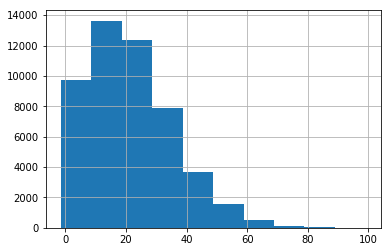

In [428]:
df_master_opp['DK_PTS'].hist()

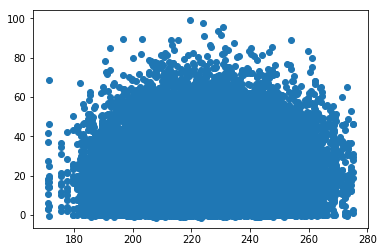

In [429]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

defense_df = df_master_opp[['OPP_DK_PTS_TRAIL3','DK_PTS']]

plt.scatter(defense_df.OPP_DK_PTS_TRAIL3, defense_df.DK_PTS)


In [430]:
defense_df.corr()

,OPP_DK_PTS_TRAIL3,DK_PTS
OPP_DK_PTS_TRAIL3,1.000000,0.040687
DK_PTS,0.040687,1.000000


In [431]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method = 'yeo-johnson', standardize = True)
scaler.fit(defense_df)
defense_df_transformed = scaler.transform(defense_df)

In [432]:
defense_clean_transformed = pd.DataFrame(defense_df_transformed)

In [433]:
defense_clean_transformed.corr()

,0,1
0,1.000000,0.037706
1,0.037706,1.000000
